#Getting Data from Kaggle

In [ ]:
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iamashutoshpanda","key":"4f54af122beda97a053f32261edac364"}'}

In [ ]:
!pip install -q kaggle
!pip install kaggle --upgrade
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.8)


In [ ]:
!kaggle competitions download -c dogs-vs-cats

 96% 261M/271M [00:01<00:00, 205MB/s]
100% 271M/271M [00:01<00:00, 187MB/s]
 99% 540M/543M [00:03<00:00, 157MB/s]
100% 543M/543M [00:03<00:00, 169MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 25.5MB/s]


In [ ]:
!unzip test1.zip
!unzip train.zip

#Dog Cat CNN

## Basic Imports

In [76]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## Constants for training

In [77]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Making the input dataframe
In the train folder we have images of cats & dogs both 
We will make a dataframe with 2 columns
'filename' & 'category' if the filename will be of a dog then type will be 1

dog - 1
cat - 0

In [78]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [79]:
df.head()

,filename,category
0,dog.528.jpg,1
1,dog.4966.jpg,1
2,dog.1263.jpg,1
3,dog.7768.jpg,1
4,cat.9927.jpg,0


## Visualizing datset
So we have 12,000 images in each category

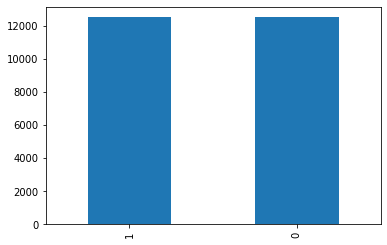

In [80]:
df['category'].value_counts().plot.bar()

## Insight about shape of the data
The images are of different dimensions 

Run the cell below many times 

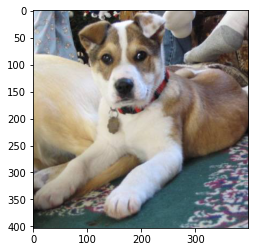

In [81]:
random_filename = random.choice(filenames)
image = load_img("train/"+random_filename)
plt.imshow(image)

## Making the model

In [82]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
# output channels =32 filter dimension = (3,3) 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# increasing channels as we go as the height x width has decreased
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# increasing channels as we go as the height x width has decreased
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

##Callbacks
We will use 2 callbacks  namely 

EarlyStopping : this will stop the training when the metric we have given stops improving

ReduceLROnPlateau : this will change the learning rate if the metric we have set stops improving over time

In [83]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

patience :  Number of epochs with no improvement after which training will be stopped. 





In [84]:
earlystop = EarlyStopping(patience=10)

Once the learning stagnates it is seen that the model improves if we reduce the learning rate by a factor 2-10
i.e lr = lr/2 or lr/=3 ... lr/=10 [ANY]

---

 **monitor**: quantity to be monitored.

 **factor**: factor by which the learning rate will be reduced. new_lr = lr * factor.

**patience**: number of epochs with no improvement after which learning rate will be reduced.

**verbose**: int. 0: quiet, 1: update messages.

In [85]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [86]:
callbacks = [earlystop, learning_rate_reduction]

## One-Hot encoding
Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [87]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
print("Total images",len(df))
df.head()


Total images 25000


,filename,category
0,dog.528.jpg,dog
1,dog.4966.jpg,dog
2,dog.1263.jpg,dog
3,dog.7768.jpg,dog
4,cat.9927.jpg,cat


## Dividing the dataset into training & validation
We have total 25k images 

train = 4/5 * 25k = 20k

validation = 1/5 * 25k = 5k

In [88]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [89]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

print("total training images",total_train)
print("total validation images",total_validate)

total training images 20000
total validation images 5000


## Making Image Generator for training

In [90]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Making Image Generator for validation
One thing to note here is that validation generator is very different from the training generator 

It is like this because the training & validation images should not be very similar to keep them different we have made seperate kinds of image generators

In [91]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


##Visualising the training image generator
We have made example_generator from a sample of train-dataframe

Found 1 validated image filenames belonging to 1 classes.


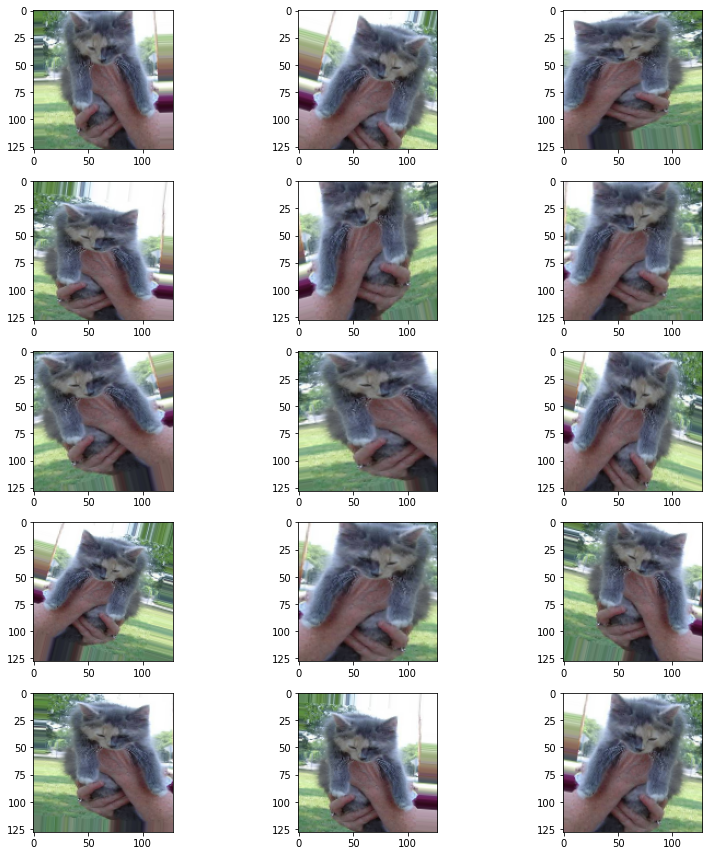

In [92]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

##Fitting the model

In [ ]:
epochs=50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
loss, accuracy  = model.evaluate(test_images, test_labels, verbose=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 484/1333 [=========>....................] - ETA: 11:31 - loss: 0.9590 - accuracy: 0.5720

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')